In [ ]:
import sys
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
import random
import os
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import spatial
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as tfuu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)
import GPy
from wbml.plot import tweak
from stheno import B, Measure, GP, EQ, Delta
import torch

#1 11 2021
#Dist_prism_12 = 1.0398341231585624*1000
#Dist_prism_13 = 0.818424700118086*1000
#Dist_prism_23 = 0.8806156053859284*1000
#Dist_GPS_12 = 0.835637436093363*1000
#Dist_GPS_13 = 0.7812173648662254*1000
#Dist_GPS_23 = 0.5166745729506486*1000

# Traj 1-2-3
P1 = np.array([[1,0,0,0.5],[0,1,0,-0.25],[0,0,1,0.3],[0,0,0,1]])
P2 = np.array([[1,0,0,-0.1],[0,1,0,0.4],[0,0,1,0.2],[0,0,0,1]])
P3 = np.array([[1,0,0,-0.7],[0,1,0,0],[0,0,1,0.4],[0,0,0,1]])

# Traj 4-5
#P1 = np.array([[1,0,0,0.6],[0,1,0,-0.35],[0,0,1,0.4],[0,0,0,1]])
#P2 = np.array([[1,0,0,-0.2],[0,1,0,0.3],[0,0,1,0.15],[0,0,0,1]])
#P3 = np.array([[1,0,0,-0.65],[0,1,0,0],[0,0,1,0.35],[0,0,0,1]])

# Traj 6
#P1 = np.array([[1,0,0,-0.6],[0,1,0,0.35],[0,0,1,0.4],[0,0,0,1]])
#P2 = np.array([[1,0,0,0.2],[0,1,0,-0.3],[0,0,1,0.15],[0,0,0,1]])
#P3 = np.array([[1,0,0,0.65],[0,1,0,0],[0,0,1,0.35],[0,0,0,1]])

# Distance in meter
Dist_prism_12 = np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P2[0,3],P2[1,3],P2[2,3]]))
Dist_prism_13 = np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]]))
Dist_prism_23 = np.linalg.norm(np.array([P2[0,3],P2[1,3],P2[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]]))
cov_prism = np.array([[0.002,0,0],[0,0.002,0],[0,0,0.002]])
D12_wref = np.sqrt(np.linalg.norm(P1-P2)*np.linalg.norm(P1-P2)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace())
D13_wref = np.sqrt(np.linalg.norm(P1-P3)*np.linalg.norm(P1-P3)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace())
D23_wref = np.sqrt(np.linalg.norm(P2-P3)*np.linalg.norm(P2-P3)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace())
#print(Dist_prism_12,Dist_prism_13,Dist_prism_23)
#print(D12_wref,D13_wref,D23_wref)

In [ ]:
tfuu = importlib.reload(tfuu)
path = "./data/simulation/"
trajectoire = "2"

time_trimble_1, trimble_1 = tfuu.read_point_data_csv_file(path+"/"+trajectoire+"/"+trajectoire+"_s_sync_p_1"+".csv")
time_trimble_2, trimble_2 = tfuu.read_point_data_csv_file(path+"/"+trajectoire+"/"+trajectoire+"_s_sync_p_2"+".csv")
time_trimble_3, trimble_3 = tfuu.read_point_data_csv_file(path+"/"+trajectoire+"/"+trajectoire+"_s_sync_p_3"+".csv")

# Work on the data with 3 prisms and 3 theodolites
tfu = importlib.reload(tfu)
# Slipt the data into different interval according to the timestamps of the measurements
limit_time_interval = 3    #4 seconds max
list_interval, list_time = tfu.split_time_interval_all_data(time_trimble_1, time_trimble_2, time_trimble_3, limit_time_interval)
# Keep only the intervals where the three theodlites have done some measurements at the same time
limit_search = 4
list_trajectories_split = tfu.merge_interval(list_interval, list_time, time_trimble_1, time_trimble_2, time_trimble_3, limit_search)
print("Number sub-trajectories:",len(list_trajectories_split))
# Plot subtrajectory for debug
#tfu.plot_subtrajectory_result(0, list_trajectories_split, trimble_1, trimble_2, trimble_3)

In [ ]:
%matplotlib notebook
d12_ref = []
d13_ref = []
d23_ref = []
t1 = np.array(trimble_1).T
t2 = np.array(trimble_2).T
t3 = np.array(trimble_3).T

for i,j,k in zip(t1, t2 ,t3):
    p1 = np.array([i[0],i[1],i[2]])
    p2 = np.array([j[0],j[1],j[2]])
    p3 = np.array([k[0],k[1],k[2]])
    d12_ref.append(abs(np.linalg.norm(p1-p2))*1000)
    d13_ref.append(abs(np.linalg.norm(p1-p3))*1000)
    d23_ref.append(abs(np.linalg.norm(p2-p3))*1000)

print(np.mean(abs(d12_ref-Dist_prism_12*1000)),np.mean(abs(d13_ref-Dist_prism_13*1000)),np.mean(abs(d23_ref-Dist_prism_23*1000)))
plt.plot(time_trimble_1, d12_ref-Dist_prism_12*1000, label = "s12")
plt.plot(time_trimble_1, d13_ref-Dist_prism_13*1000, label = "s13")
plt.plot(time_trimble_1, d23_ref-Dist_prism_23*1000, label = "s23")
plt.legend(loc='best')
plt.show()

In [ ]:
import scripts.theodolite_utils as tfuu
tfuu = importlib.reload(tfuu)
import warnings
import time
warnings.filterwarnings('ignore')
tfu = importlib.reload(tfu)
GPf = importlib.reload(GPf)
path = "./data/prediction/"
path_data = "./data/simulation/"
B.epsilon = 1e-8
save = True
begin = 5
end = 54
rate = 10  #Hz
T_prediction_init = torch.from_numpy(np.arange(begin, end, 1/rate))
verbose=False
noise_GP = 0
variance_GP = 1
lengthscale_GP = 1
limit_points_windows = [0,0]
Mode_window = "ground-truth"

mode_arr = ["FGP", "FGP", "FGP", "FGP"]
size_interval_arr = [15, 20, 25, 30]
number_restart_arr = [10, 10, 10, 10]
trajectoire_arr = ["15-10", "20-10", "25-10", "30-10"]
file_open = [path_data+"2/2_s_sync_p_", path_data+"2/2_s_sync_p_", path_data+"2/2_s_sync_p_", path_data+"2/2_s_sync_p_"]
file_save = [path+"2/2-"+mode_arr[0]+"-"+trajectoire_arr[0]+"_s_sync_p_",
            path+"2/2-"+mode_arr[1]+"-"+trajectoire_arr[1]+"_s_sync_p_",
            path+"2/2-"+mode_arr[2]+"-"+trajectoire_arr[2]+"_s_sync_p_",
            path+"2/2-"+mode_arr[3]+"-"+trajectoire_arr[3]+"_s_sync_p_"]

for m,n,p,r,s,nr in zip(mode_arr, size_interval_arr, trajectoire_arr, file_open, file_save, number_restart_arr):
    
    time_trimble_1, trimble_1 = tfuu.read_point_data_csv_file(r+"1"+".csv")
    time_trimble_2, trimble_2 = tfuu.read_point_data_csv_file(r+"2"+".csv")
    time_trimble_3, trimble_3 = tfuu.read_point_data_csv_file(r+"3"+".csv")
    limit_time_interval = 10 
    list_interval, list_time = tfu.split_time_interval_all_data(time_trimble_1, time_trimble_2, time_trimble_3, limit_time_interval)
    limit_search = 4
    list_trajectories_split = tfu.merge_interval(list_interval, list_time, time_trimble_1, time_trimble_2, time_trimble_3, limit_search)
    
    start_time = time.time()
    Mode = m
    trajectoire = p
    size_interval = n
    
    Number_points_window = []
    Prediction_1_MGPO = []
    Prediction_2_MGPO = []
    Prediction_3_MGPO = []
    Prediction_1_GP = []
    Prediction_2_GP = []
    Prediction_3_GP = []
    T_prediction = []
    compteur = 0
    max_compteur = len(T_prediction_init)

    for i in T_prediction_init.numpy():
        prediction_value = torch.tensor(i)
        # Check if timestamp is in the interval of ground truth
        isInInterval, time_1, time_2, time_3, traj_1, traj_2, traj_3 = GPf.check_if_in_interval(list_trajectories_split, size_interval, time_trimble_1, time_trimble_2, time_trimble_3, trimble_1, trimble_2, trimble_3, i)
        
        if(isInInterval == True):
            # Find the index needed for the training
            #index_1, index_2, index_3 = GPf.define_window_training(time_1, time_2, time_3, size_interval, i)
            index_1, index_2, index_3 = GPf.define_time_window_training(time_1, time_2, time_3, size_interval, i, limit_points_windows, Mode_window)
            
            if(index_1[0]!=-1):
                Number_points_window.append(np.array([index_1[1]-index_1[0],index_2[1]-index_2[0],index_3[1]-index_3[0]]))
                if(Mode=="GP"):
                    # Prepare data for training
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = GPf.data_training_GP_stheno(time_1, time_2, time_3, traj_1, traj_2, traj_3, index_1, index_2, index_3)
                    # Training for each axis
                    m_X1, v_X1 = GPf.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=X1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=nr)
                    m_Y1, v_Y1 = GPf.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=Y1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=nr)
                    m_Z1, v_Z1 = GPf.GP_function_stheno(x=prediction_value, x_obs=T1, y_obs=Z1, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=nr)
                    m_X2, v_X2 = GPf.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=X2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=nr)
                    m_Y2, v_Y2 = GPf.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=Y2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=nr)
                    m_Z2, v_Z2 = GPf.GP_function_stheno(x=prediction_value, x_obs=T2, y_obs=Z2, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=nr)
                    m_X3, v_X3 = GPf.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=X3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=nr)
                    m_Y3, v_Y3 = GPf.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=Y3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=nr)
                    m_Z3, v_Z3 = GPf.GP_function_stheno(x=prediction_value, x_obs=T3, y_obs=Z3, variance=variance_GP, lengthscale=lengthscale_GP, noise_init=noise_GP, optimization_nb=nr)
                    # Save prediction at time i
                    Prediction_1_GP.append(np.array([i, m_X1[0], m_Y1[0], m_Z1[0], v_X1[0], v_Y1[0], v_Z1[0]]))
                    Prediction_2_GP.append(np.array([i, m_X2[0], m_Y2[0], m_Z2[0], v_X2[0], v_Y2[0], v_Z2[0]]))
                    Prediction_3_GP.append(np.array([i, m_X3[0], m_Y3[0], m_Z3[0], v_X3[0], v_Y3[0], v_Z3[0]]))
                    T_prediction.append(i)

                if(Mode == "MGPO" or Mode == "All"):
                    T_MGPO, S_MGPO = GPf.data_training_MGPO(time_1, time_2, time_3, traj_1, traj_2, traj_3, index_1, index_2, index_3)
                    m = GPf.training_MGPO(nr, verbose, T_MGPO, S_MGPO)
                    P1_MGPO, P2_MGPO, P3_MGPO = GPf.unit_prediction_MGPO(i, m)
                    Prediction_1_MGPO.append(P1_MGPO)
                    Prediction_2_MGPO.append(P2_MGPO)
                    Prediction_3_MGPO.append(P3_MGPO)
                    T_prediction.append(i)

                if(Mode=="VGP"):
                    # Prepare data for training
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = GPf.data_training_GP_stheno(time_1, time_2, time_3, traj_1, traj_2, traj_3, index_1, index_2, index_3)
                    prior = OILMM(tf.float32, build_latent_processes, num_outputs=9)

                    # Create some sample data.
                    #x = np.linspace(0, 10, 100)
                    #y = prior.sample(x)  # Sample from the prior.
                    x = [T1, T1, T1, T2, T2, T2, T3, T3, T3]
                    y = [X1, Y1, Z1, X2, Y2, Z2, X3, Y3, Z3]

                    # Fit the model to the data.
                    prior.fit(x, y, trace=True, jit=True)
                    prior.vs.print()  # Print all learned parameters.

                    # Make predictions.
                    posterior = prior.condition(x, y)  # Construct posterior model.
                    mean, var = posterior.predict(x)  # Predict with the posterior model.
                    
                if(Mode == "FGP" or Mode == "All"):
                    T1, X1, Y1, Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3 = GPf.data_training_GP(time_1, time_2, time_3, traj_1, 
                                                                         traj_2, traj_3, index_1, index_2, index_3)
                    mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3 = GPf.training_GP(nr, verbose, T1, X1, Y1,
                                                                              Z1, T2, X2, Y2, Z2, T3, X3, Y3, Z3)
                    P1_GP, P2_GP, P3_GP = GPf.unit_prediction_GP(i, mx1, my1, mz1, mx2, my2, mz2, mx3, my3, mz3)
                    Prediction_1_GP.append(P1_GP)
                    Prediction_2_GP.append(P2_GP)
                    Prediction_3_GP.append(P3_GP)
                    T_prediction.append(i)
                
        if(compteur/max_compteur*100 % 10 == 0):
            print(compteur/max_compteur*100)
        compteur=compteur+1
        
    stop_time = time.time()
    print(stop_time - start_time)
        
    if(Mode == "MGPO" or Mode == "All"):
        if save:
            tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_MGPO, s+"1.csv")
            tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_MGPO, s+"2.csv")
            tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_MGPO, s+"3.csv")
    if(Mode == "GP" or Mode == "All" or Mode == "FGP"):
        if save:
            tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_GP, s+"1.csv")
            tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_GP, s+"2.csv")
            tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_GP, s+"3.csv")

    print("Finished !")

In [ ]:
%matplotlib notebook
Prediction_1 = np.array(Prediction_1_GP)
Prediction_2 = np.array(Prediction_2_GP)
Prediction_3 = np.array(Prediction_3_GP)
time_theoric_arr = np.array(T_prediction)
number_points_arr = np.array(Number_points_window)
plt.figure(0)
coord = 1
plt.scatter(time_theoric_arr, Prediction_1[:,coord+1], label="x1", marker="*", s = 15, color="r")
plt.scatter(time_theoric_arr, Prediction_2[:,coord+1], label="x2", marker="*", s = 20, color="yellow")
plt.scatter(time_theoric_arr, Prediction_3[:,coord+1], label="x3", marker="*", s = 15, color="orange")
plt.scatter(time_trimble_1[0:-1], trimble_1[1,0:-1], label="t1", marker="+", s=10)
plt.scatter(time_trimble_2[0:-1], trimble_2[1,0:-1], label="t2", marker="+", s=10)
plt.scatter(time_trimble_3[0:-1], trimble_3[1,0:-1], label="t3", marker="+", s=10)
#plt.plot(time_theoric_arr,number_points_arr)
ax = plt.gca()
#ax.set_yscale('symlog')
#plt.legend(loc='best')
#ax.set_ylim([0, 25])
plt.show()   

In [ ]:
%matplotlib notebook
Prediction_1 = np.array(Prediction_1_MGPO)
Prediction_2 = np.array(Prediction_2_MGPO)
Prediction_3 = np.array(Prediction_3_MGPO)
time_theoric_arr = np.array(T_prediction)
number_points_arr = np.array(Number_points_window)
plt.figure(0)
coord = 1
plt.scatter(time_theoric_arr, Prediction_1[:,coord+1], label="x1", marker="*", s = 15, color="r")
plt.scatter(time_theoric_arr, Prediction_2[:,coord+1], label="x2", marker="*", s = 20, color="yellow")
plt.scatter(time_theoric_arr, Prediction_3[:,coord+1], label="x3", marker="*", s = 15, color="orange")
plt.scatter(time_trimble_1[0:-1], trimble_1[1,0:-1], label="t1", marker="+", s=10)
plt.scatter(time_trimble_2[0:-1], trimble_2[1,0:-1], label="t2", marker="+", s=10)
plt.scatter(time_trimble_3[0:-1], trimble_3[1,0:-1], label="t3", marker="+", s=10)
#plt.plot(time_theoric_arr,number_points_arr)
ax = plt.gca()
#ax.set_yscale('symlog')
#plt.legend(loc='best')
#ax.set_ylim([0, 25])
plt.show()   

In [ ]:
%matplotlib notebook
error_euclidian_GP, distance_wasserstein_GP, error_wasserstein_diff_GP, T_prediction = GPf.error_calculation(Prediction_1_GP, 
            Prediction_2_GP, Prediction_3_GP, Dist_prism_12, Dist_prism_13, Dist_prism_23, D12_wref, D13_wref, D23_wref)
error_e_GP = np.array(error_euclidian_GP)
distance_w_GP = np.array(distance_wasserstein_GP)
error_w_diff_GP = np.array(error_wasserstein_diff_GP)
print("Mean e: ", np.mean(error_e_GP[:,0]),np.mean(error_e_GP[:,1]),np.mean(error_e_GP[:,2]))
print("Variance e: ", np.std(error_e_GP[:,0]),np.std(error_e_GP[:,1]),np.std(error_e_GP[:,2]))
print("Mean w: ", np.mean(error_w_diff_GP[:,0]),np.mean(error_w_diff_GP[:,1]),np.mean(error_w_diff_GP[:,2]))
print("Variance w: ", np.std(error_w_diff_GP[:,0]),np.std(error_w_diff_GP[:,1]),np.std(error_w_diff_GP[:,2]))
diff_e_w = error_e_GP[:,0:3]-error_w_diff_GP
plt.figure(0)
plt.plot(T_prediction, error_e_GP[:,0], label="e12")
plt.plot(T_prediction, error_e_GP[:,1], label="e13")
plt.plot(T_prediction, error_e_GP[:,2], label="e23")
#plt.plot(T_prediction, distance_w_GP[:,0], label="w12")
#plt.plot(T_prediction, distance_w_GP[:,1], label="w13")
#plt.plot(T_prediction, distance_w_GP[:,2], label="w23")
#plt.plot(T_prediction, error_w_diff_GP[:,0], label="dw12")
#plt.plot(T_prediction, error_w_diff_GP[:,1], label="dw13")
#plt.plot(T_prediction, error_w_diff_GP[:,2], label="dw23")
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
#ax.set_ylim([0, 1])
plt.show()

In [ ]:
%matplotlib notebook
error_euclidian_MGPO, distance_wasserstein_MGPO, error_wasserstein_diff_MGPO, T_prediction = GPf.error_calculation(Prediction_1_MGPO, 
            Prediction_2_MGPO, Prediction_3_MGPO, Dist_prism_12, Dist_prism_13, Dist_prism_23, D12_wref, D13_wref, D23_wref)
error_e_MGPO = np.array(error_euclidian_MGPO)
distance_w_MGPO = np.array(distance_wasserstein_MGPO)
error_w_diff_MGPO = np.array(error_wasserstein_diff_MGPO)
print("Mean e: ", np.mean(error_e_MGPO[:,0]),np.mean(error_e_MGPO[:,1]),np.mean(error_e_MGPO[:,2]))
print("Variance e: ", np.std(error_e_MGPO[:,0]),np.std(error_e_MGPO[:,1]),np.std(error_e_MGPO[:,2]))
print("Mean w: ", np.mean(error_w_diff_MGPO[:,0]),np.mean(error_w_diff_MGPO[:,1]),np.mean(error_w_diff_MGPO[:,2]))
print("Variance w: ", np.std(error_w_diff_MGPO[:,0]),np.std(error_w_diff_MGPO[:,1]),np.std(error_w_diff_MGPO[:,2]))
diff_e_w = error_e_MGPO[:,0:3]-error_w_diff_MGPO
plt.figure(0)
plt.plot(T_prediction, error_e_MGPO[:,0], label="e12")
plt.plot(T_prediction, error_e_MGPO[:,1], label="e13")
plt.plot(T_prediction, error_e_MGPO[:,2], label="e23")
#plt.plot(T_prediction, distance_w_GP[:,0], label="w12")
#plt.plot(T_prediction, distance_w_GP[:,1], label="w13")
#plt.plot(T_prediction, distance_w_GP[:,2], label="w23")
#plt.plot(T_prediction, error_w_diff_GP[:,0], label="dw12")
#plt.plot(T_prediction, error_w_diff_GP[:,1], label="dw13")
#plt.plot(T_prediction, error_w_diff_GP[:,2], label="dw23")
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
#ax.set_ylim([0, 1])
plt.show()

In [ ]:
save = True
if(Mode == "MGPO" or Mode == "All"):
    path = "./data/prediction/"
    trajectoire = "2-10"
    if save:
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_MGPO, path+trajectoire+ "_MGPO_s_sync_p_1.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_MGPO, path+trajectoire+ "_MGPO_s_sync_p_2.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_MGPO, path+trajectoire+ "_MGPO_s_sync_p_3.csv")
if(Mode == "FGP" or Mode == "All"):
    path = "./data/prediction/"
    trajectoire = "2-FGP-10-5"
    if save:
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_1_GP, path+trajectoire+ "_GP_s_sync_p_1.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_2_GP, path+trajectoire+ "_GP_s_sync_p_2.csv")
        tfu.Convert_data_prediction_to_csv(T_prediction, Prediction_3_GP, path+trajectoire+ "_GP_s_sync_p_3.csv")

In [ ]:
import matplotlib.pyplot as plt
from wbml.plot import tweak
from stheno import B, Measure, GP, EQ, Delta, Matern52

class VGP:
    """A vector-valued GP."""

    def __init__(self, ps):
        self.ps = ps

    def __add__(self, other):
        return VGP([f + g for f, g in zip(self.ps, other.ps)])

    def lmatmul(self, A):
        m, n = A.shape
        ps = [0 for _ in range(m)]
        for i in range(m):
            for j in range(n):
                ps[i] += A[i, j] * self.ps[j]
        return VGP(ps)


# Define points to predict at.
x = B.linspace(0, 10, 5)

# Create some sample data.
x1 = np.atleast_2d(np.linspace(0, 10, 5)).T
x2 = np.atleast_2d(np.linspace(0, 9, 5)).T
x3 = np.atleast_2d(np.linspace(0, 7, 5)).T
y1 = np.atleast_2d(np.linspace(0, 10, 5)).T
y2 = np.atleast_2d(np.linspace(0, 10, 5)).T
y3 = np.atleast_2d(np.linspace(0, 10, 5)).T

x_obs = [x1,x2,x3]
y_obs = [y1,y2,y3]

# Model parameters:
m = 3
p = 3
H = B.randn(p, m)

with Measure() as prior:
    # Construct latent functions.
    us = VGP([GP(Matern52()) for _ in range(m)])
    # Construct multi-output prior.
    fs = us.lmatmul(H)
    # Construct noise.
    e = VGP([GP(0 * Delta()) for _ in range(p)])
    # Construct observation model.
    ys = e + fs

# Sample a true, underlying function and observations.
samples = prior.sample(*(p(x) for p in zip(fs.ps)), *(p(x_obs) for p, x_obs in zip(ys.ps, x_obs)))
fs_true, ys_obs = samples[:p], samples[p:]

# Compute the posterior and make predictions.
post = prior.condition(*((p(x_obs), y_obs) for p, y_obs, x_obs in zip(ys.ps, ys_obs, x_obs)))
preds = [post(p(x)) for p in fs.ps]

# Plot results.
def plot_prediction(x, f, pred, x_obs=None, y_obs=None):
    plt.plot(x, f, label="True", style="test")
    if x_obs is not None:
        plt.scatter(x_obs, y_obs, label="Observations", style="train", s=20)
    mean, lower, upper = pred.marginal_credible_bounds()
    plt.plot(x, mean, label="Prediction", style="pred")
    plt.fill_between(x, lower, upper, style="pred")
    tweak()


plt.figure(figsize=(10, 6))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.title(f"Output {i + 1}")
    plot_prediction(x, fs_true[i], preds[i], x_obs, ys_obs[i])
plt.show()

In [ ]:
from stheno.jax import GP, Matern52, Measure
from varz.jax import Vars, minimise_l_bfgs_b
from wbml.plot import tweak

import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

x1 = np.linspace(0, 10, 30)
x2 = np.linspace(0, 9, 40)
x3 = np.linspace(0, 7, 50)

# Generate some test data.
f = GP(Matern52())
y1 = f(x1, 0.2).sample().flatten()
y2 = f(x2, 0.2).sample().flatten()
y3 = f(x3, 0.2).sample().flatten()

p = 3  # Number of outputs
m = 3  # Number of latent processes


def model(vs):
    ps = vs.struct

    with Measure() as prior:
        # Create independent processes with learnable length scales initialised to `1`.
        us = [
            GP(Matern52().stretch(ps_u.scale.positive(1)))
            for ps_u, _ in zip(ps.us, range(p))
        ]

        # Mix processes together to induce correlations between the outputs.
        H = ps.mixing_matrix.unbounded(shape=(p, m))
        fs = [0 for _ in range(p)]
        for i in range(p):
            for j in range(m):
                fs[i] = fs[i] + H[i, j] * us[j]

        # Create learnable observation noises initialised to `0.1`
        noises = ps.noises.positive(0.1, shape=(p,))

    return prior, fs, noises


def objective(vs):
    prior, fs, noises = model(vs)
    return -prior.logpdf(
        (fs[0](x1, noises[0]), y1),
        (fs[1](x2, noises[1]), y2),
        (fs[2](x3, noises[2]), y3),
    )

# Perform learning.
vs = Vars(jnp.float64)
minimise_l_bfgs_b(objective, vs, trace=True, jit=True)
vs.print()  # Display learned parameters.

# Compute posterior and predictions.
prior, fs, noises = model(vs)
posterior = prior | (
    (fs[0](x1, noises[0]), y1),
    (fs[1](x2, noises[1]), y2),
    (fs[2](x3, noises[2]), y3),
)
f1_post = posterior(fs[0])
f2_post = posterior(fs[1])
f3_post = posterior(fs[2])

In [ ]:
def plot_posterior(x, f, x_obs=None, y_obs=None):
    if x_obs is not None:
        plt.scatter(x_obs, y_obs, label="Observations", style="train", s=20)
    mean, lower, upper = f(x).marginal_credible_bounds()
    plt.plot(x, mean, label="Prediction", style="pred")
    plt.fill_between(x, lower, upper, style="pred")
    tweak()

# Plot results.
plt.figure(figsize=(18, 10))
x_to_plot = np.linspace(0, 10, 200)
plt.subplot(9, 1, 1)
plt.title("Output 1")
plot_posterior(x_to_plot, f1_post, x1, y1)
plt.subplot(9, 1, 2)
plt.title("Output 2")
plot_posterior(x_to_plot, f2_post, x2, y2)
plt.subplot(9, 1, 3)
plt.title("Output 3")
plot_posterior(x_to_plot, f3_post, x3, y3)
plt.subplot(9, 1, 4)
plt.title("Output 4")
plot_posterior(x_to_plot, f4_post, x4, y4)
plt.subplot(9, 1, 5)
plt.title("Output 5")
plot_posterior(x_to_plot, f5_post, x5, y5)
plt.subplot(9, 1, 6)
plt.title("Output 6")
plot_posterior(x_to_plot, f6_post, x6, y6)
plt.subplot(9, 1, 7)
plt.title("Output 7")
plot_posterior(x_to_plot, f7_post, x7, y7)
plt.subplot(9, 1, 8)
plt.title("Output 8")
plot_posterior(x_to_plot, f8_post, x8, y8)
plt.subplot(9, 1, 9)
plt.title("Output 9")
plot_posterior(x_to_plot, f9_post, x9, y9)
plt.show()

In [ ]:
#from stheno.jax import GP, Matern52, Measure
#from varz.jax import Vars, minimise_l_bfgs_b
#from varz.tensorflow import Vars, minimise_adam
from wbml.plot import tweak
from stheno.torch import EQ, GP, Matern52, Measure
import torch
import lab as B
from varz import Vars, minimise_l_bfgs_b, parametrised, Positive
import matplotlib.pyplot as plt
import numpy as np

B.epsilon = 1e-6
x1 = torch.linspace(0, 10, 20)
x2 = torch.linspace(0, 9, 20)

# Generate some test data.
f = GP(Matern52())
y1 = f(x1, 0).sample().flatten()
y2 = f(x2, 0).sample().flatten()
#y3 = f(x3, 0).sample().flatten()
#y1 = f(x1, 0).sample()
#y2 = f(x2, 0).sample()
#y3 = f(x3, 0).sample()

#y1 = torch.linspace(0, 10, 20)
#y2 = torch.linspace(0, 9, 20)

p = 2  # Number of outputs
m = 2  # Number of latent processes

def model(vs):
    ps = vs.struct

    with Measure() as prior:
        # Create independent processes with learnable length scales initialised to `1`.
        us = [
            GP(ps_u.variance.positive(1) * Matern52().stretch(ps_u.scale.positive(1)))
            for ps_u, _ in zip(ps.us, range(p))
        ]

        # Mix processes together to induce correlations between the outputs.
        H = ps.mixing_matrix.unbounded(shape=(p, m))
        fs = [0 for _ in range(p)]
        for i in range(p):
            for j in range(m):
                fs[i] = fs[i] + H[i, j] * us[j]

        # Create learnable observation noises initialised to `0.1`
        noises = ps.noises.positive(0, shape=(p,))

    return prior, fs, noises

def objective(vs):
    prior, fs, noises = model(vs)
    return -prior.logpdf(
        (fs[0](x1,noises[0]), y1),
        (fs[1](x2, noises[1]), y2)
    )

# Perform learning.
vs = Vars(torch.float32)
#vs = Vars(jnp.float64)
#minimise_adam(objective, vs, rate=5e-3, iters=5, trace=True, jit=True)
#minimise_l_bfgs_b(objective, vs, trace=True, jit=True, iters=20)
minimise_l_bfgs_b(objective, vs, iters=10, trace=True, jit=False)
vs.print()  # Display learned parameters.

# Compute posterior and predictions.
prior, fs, noises = model(vs)
posterior = prior | (
    (fs[0](x1, noises[0]), y1),
    (fs[1](x2, noises[1]), y2),
)
f1_post = posterior(fs[0])
f2_post = posterior(fs[1])

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

size = 3000
x = random.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

In [ ]:
import numpy as np
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

In [ ]:
from jax import device_put

x = np.random.normal(size=(size, size)).astype(np.float32)
x = device_put(x)
%timeit jnp.dot(x, x.T).block_until_ready()

In [ ]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()

In [ ]:
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

In [ ]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from gpflow.ci_utils import ci_niter

plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(123)

In [ ]:
# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1)  # Observed locations for first output
X2 = np.random.rand(50, 1) * 0.5  # Observed locations for second output
X3 = np.random.rand(50, 1) * 0.8  # Observed locations for third output

Y1 = np.sin(6 * X1) + np.random.randn(*X1.shape) * 0.03
Y2 = np.sin(6 * X2 + 0.7) + np.random.randn(*X2.shape) * 0.1
Y3 = np.sin(8 * X3 + 0.7) + np.random.randn(*X3.shape) * 0.1

plt.figure(figsize=(8, 4))
plt.plot(X1, Y1, "x", mew=2)
_ = plt.plot(X2, Y2, "x", mew=2)
_ = plt.plot(X3, Y3, "x", mew=2)

In [ ]:
# Augment the input with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2))),
                         np.hstack((X3, np.ones_like(X3)*2))))

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(Y1))), np.hstack((Y2, np.ones_like(Y2))),
                         np.hstack((Y3, np.ones_like(Y3)*2))))

In [ ]:
output_dim = 3  # Number of outputs
rank = 3  # Rank of W
# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0,1,2])
# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[0,1,2])
kern = k * coreg
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()]
)

# now buld the GP model as normal
m = gpflow.models.VGP(X_augmented, Y_augmented, kern=kern, likelihood=lik, num_latent=1)
# fit the covariance function parameters
gpflow.train.ScipyOptimizer().minimize(m)

# now build the GP model as normal
#m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
#maxiter = ci_niter(10000)
#gpflow.optimizers.Scipy().minimize(
#    m.training_loss,
#    m.trainable_variables,
#    options=dict(maxiter=maxiter),
#    method="L-BFGS-B",
#)

In [ ]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(m):
    plt.figure(figsize=(8, 4))
    Xtest = np.linspace(0, 1, 100)[:, None]
    (line,) = plt.plot(X1, Y1, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.zeros_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y1")

    (line,) = plt.plot(X2, Y2, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y2")

    plt.legend()


plot(m)

In [ ]:
B = coreg.output_covariance().numpy()
print("B =", B)
_ = plt.imshow(B)

In [ ]:
X1 = np.random.rand(100, 1)
X2 = np.random.rand(100, 1) 
X3 = np.random.rand(100, 1) 

Y1 = np.sin(6*X1) + np.random.standard_t(3, X1.shape)*0.03
Y2 = np.sin(6*X2+ 0.7) + np.random.standard_t(3, X2.shape)*0.1
Y3 = np.sin(5*X3- 0.3) + np.random.standard_t(3, X3.shape)*0.1

plt.plot(X1, Y1, 'x', mew=2)
plt.plot(X2, Y2, 'x', mew=2)
plt.plot(X3, Y3, 'x', mew=2)
plt.show()

In [ ]:
# make a dataset with 3 outputs
output_dim = 3  # Number of outputs
rank = 3  # Rank of W

# Augment the time data with ones or zeros to indicate the required output dimension
X_augmented = np.vstack(
    (np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2))), np.hstack((X3, 2*np.ones_like(X3))))
)

# Augment the Y data to indicate which likeloihood we should use
Y_augmented = np.vstack(
    (np.hstack((Y1, np.zeros_like(X1))), np.hstack((Y2, np.ones_like(X2))), np.hstack((Y3, 2*np.ones_like(X3))))
)

# Build Likelihood
lik = gpflow.likelihoods.SwitchedLikelihood([
    gpflow.likelihoods.StudentT(), gpflow.likelihoods.StudentT(), gpflow.likelihoods.StudentT()
])

# Base Matern kernel
k1 = gpflow.kernels.Matern32(1, active_dims=[0,1])

# Build the coreg kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[2])
kern = k1 *  coreg

# now buld the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
# fit the covariance function parameters
maxiter = ci_niter(10000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=maxiter),
    method="L-BFGS-B",
)

In [ ]:
## Fit and plot
xtest = np.hstack([np.linspace(0, 1, 100)]*3)[:,None]
mu1, var1 = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
mu2, var2 = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
mu3, var3 = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
plt.plot(X1, Y1, 'x', mew=2)
plt.plot(X2, Y2, 'x', mew=2)
plt.plot(X3, Y3, 'x', mew=2)
plt.plot(np.linspace(0, 1, 100), np.reshape(mu2, [100,3]))

In [56]:
from gpflow.params import Parameterized
from gpflow.decors import params_as_tensors
from gpflow import Param
from gpflow.kernels import RBF, Stationary, Exponential
import tensorflow as tf
sess_cpu = tf.Session(config=tf.ConfigProto(device_count={'GPU': 1}))

#Xavier random initialization of NN weights
def xavier(dim_in, dim_out):
    return np.random.randn(dim_in, dim_out)*(2./(dim_in+dim_out))**0.5

class NN(Parameterized):
    def __init__(self, dims):
        Parameterized.__init__(self)
        self.dims = dims
        for i, (dim_in, dim_out) in enumerate(zip(dims[:-1], dims[1:])):
            setattr(self, 'W_{}'.format(i), Param(xavier(dim_in, dim_out)))
            setattr(self, 'b_{}'.format(i), Param(np.zeros(dim_out)))

    def forward(self, X):
        if X is not None:
            for i in range(len(self.dims) - 1):
                W = getattr(self, 'W_{}'.format(i))
                b = getattr(self, 'b_{}'.format(i))
                X = tf.nn.tanh(tf.matmul(X, W) + b)
            return X

class NN_Exponential(Exponential):
    def __init__(self, nn, *args, **kw):
        Exponential.__init__(self, *args, **kw)
        self.nn = nn
    
    @params_as_tensors
    def square_dist(self, X, X2):
        return Exponential.square_dist(self, self.nn.forward(X), self.nn.forward(X2))
        
    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        return self.variance * tf.exp(-self.square_dist(X, X2) / 2)

class NN_RBF(RBF):
    def __init__(self, nn, *args, **kw):
        RBF.__init__(self, *args, **kw)
        self.nn = nn
    
    @params_as_tensors
    def square_dist(self, X, X2):
        return RBF.square_dist(self, self.nn.forward(X), self.nn.forward(X2))
        
    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        return self.variance * tf.exp(-self.square_dist(X, X2) / 2)    

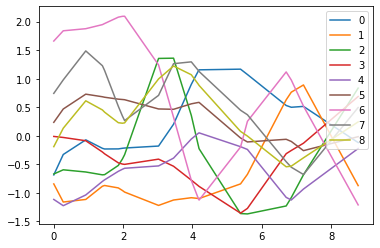

In [57]:
#https://stackoverflow.com/questions/16024677/generate-correlated-data-in-python-3-3
#http://gpflow.readthedocs.io/en/latest/notebooks/multiclass.html
#Generate your own correlated data
import numpy as np
import matplotlib.pyplot as plt
import gpflow
%matplotlib inline

npts = 20
output_dim = 9
range_ = 10
LS2 = 1   #lengthscale^2
V2 = 1      #output variance^2
noise = 1e-8 #add noise to obs

#uncorrelated data
np.random.seed(1)
X = np.random.rand(npts,1)*range_

#correlated data = uncorrelated data x Cholesky decomposition
K = V2*np.exp(-0.5*np.square(X - X.T)/LS2) + np.eye(npts)*noise
#B = np.array([0.79042061, 1.2, 0.8, 1.6])   #coregion matrix 
B = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])
f = B*np.dot(np.linalg.cholesky(K), np.random.randn(npts,output_dim))
X,f = zip(*sorted(zip(X,f)))
X,f = np.asarray(X), np.asarray(f)

l,t,y = np.zeros(0), np.zeros(0), np.zeros(0)
for i in range(output_dim):
    t = np.concatenate((t,X.flatten()))
    y = np.concatenate((y,f.T[i]))
    l = np.concatenate((l,np.ones(npts)*i))

for i in range(output_dim):
    line, = plt.plot(t[l==i], y[l==i], label=i);
plt.legend()

In [58]:
#arrange data
X = np.vstack((t,l)).T
Y = np.vstack((y,l)).T

#parameters
input_dim = 1
Q = 9   #number of latent functions
R = 9   #rank of coreg matrix

#standard kernels
#k = [gpflow.kernels.Exponential(input_dim, lengthscales=np.random.randn(input_dim)) for q in range(Q)]
k = [gpflow.kernels.RBF(input_dim, lengthscales=np.random.randn(input_dim)) for q in range(Q)]
# k = [gpflow.kernels.Exponential(input_dim, lengthscales=np.random.randn(input_dim)),
#      gpflow.kernels.Matern32(input_dim, lengthscales=np.random.randn(input_dim))]

#make LMC
coreg = [gpflow.kernels.Coregion(input_dim, output_dim=output_dim, rank=R, active_dims=[1]) for q in range(Q)]
kern = coreg[0] * k[0]
for q in range(1,Q):
    kern += coreg[q] * k[q]

lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT()]*output_dim) 
m = gpflow.models.SVGP(X, Y, kern=kern, likelihood=lik, num_latent=1, Z=X[::3].copy(), whiten=False) #you might want to use SGPR?!
m.compile()

#randomize coregionalization matrix W for best results
if Q > 1:
    m.kern.prod_1.coregion.W = np.random.randn(output_dim, R)
    m.kern.prod_2.coregion.W = np.random.randn(output_dim, R)
else:
    m.kern.coregion.W = np.random.randn(output_dim, R)
    #m.kern.coregion.kappa = np.zeros(output_dim) #force kappa terms to be 0 and untrainable
    #m.kern.coregion.kappa.set_trainable(False)

In [59]:
#optimize
gpflow.train.ScipyOptimizer().minimize(m, maxiter=100)

/home/norlab/python-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/norlab/python-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/norlab/python-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/norlab/python-env/lib/python3.6/site-packages/tensorflow_core/python/framework/

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 33.720728
  Number of iterations: 100
  Number of functions evaluations: 119


(-2.65, 1.9)

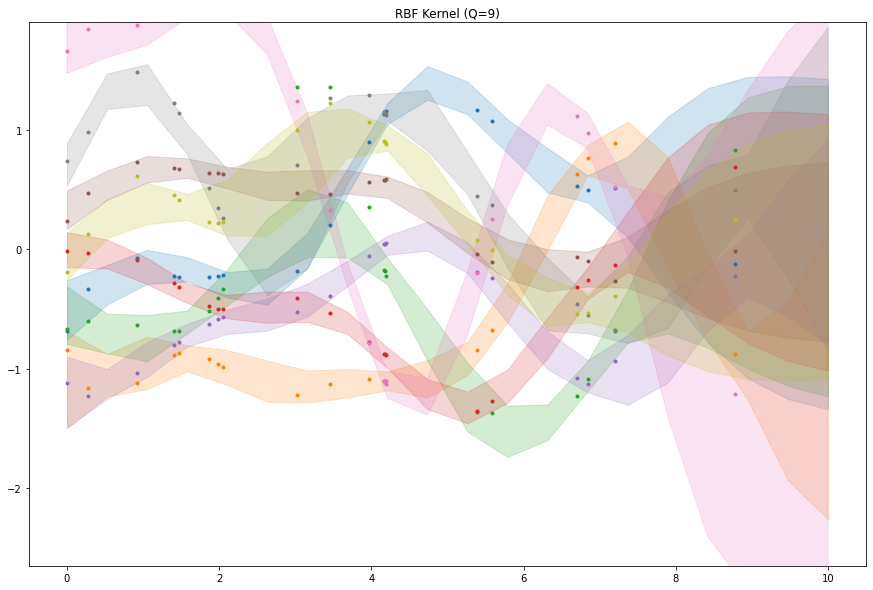

In [54]:
xtest = np.linspace(0, range_, npts)[:,None]
plt.figure(figsize=(15,10))
for i in range(output_dim):
    line, = plt.plot(t[l==i], y[l==i], '.')
    mu, var = m.predict_f(np.hstack((xtest, i+np.zeros_like(xtest))))
    #plt.plot(xtest, mu, color=line.get_color(), lw=2)
    mu, var = mu.reshape(npts,), var.reshape(npts,)
    plt.fill_between(xtest.reshape(npts,), mu-2*np.sqrt(var), mu+2*np.sqrt(var), color=line.get_color(), alpha=0.2)

kernel = "RBF"    
plt.title('%s Kernel (Q=%d)'%(kernel,Q), fontsize=12)
plt.ylim([-2.65,1.9])